```python
file1 \_ |-----------------------------------|   -+-
file2 \_ |-----------------------------------|    |   training data
file3 \_ |-----------------------------------|    |        80%
file4 \_ |-----------------------------------|    |
                                                 -+-
file5 \_ |-----------------------------------|    |  validation data
file6 \_ |-----------------------------------|    |        20%
         |-----------------------------------|   -+-
```

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from utils.MovingAverager import *

# 讀檔

In [2]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def gen_total_mag(df: pd.DataFrame):
    df['mag_x'] = moving_average(df['mag_x'], 11)
    df['mag_y'] = moving_average(df['mag_y'], 11)
    df['mag_z'] = moving_average(df['mag_z'], 11)
    
    df['mag_t'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2) + (df['mag_z'] ** 2))
    
    return df


def calculate_angle(df):
    df['acc_x'] = moving_average(df['acc_x'], 11)
    df['acc_y'] = moving_average(df['acc_y'], 11)
    df['acc_z'] = moving_average(df['acc_z'], 11)

    df['lin_acc_x'] = moving_average(df['lin_acc_x'], 11)
    df['lin_acc_y'] = moving_average(df['lin_acc_y'], 11)
    df['lin_acc_z'] = moving_average(df['lin_acc_z'], 11)
    
    df['acc_t'] = np.sqrt((df['acc_x'] ** 2) + (df['acc_y'] ** 2) + (df['acc_z'] ** 2))
    df[['gacc_x', 'gacc_y', 'gacc_z']] = df[['acc_x', 'acc_y', 'acc_z']].to_numpy() - df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']].to_numpy()
    df['gacc_t'] = np.sqrt((df['gacc_x'] ** 2) + (df['gacc_y'] ** 2) + (df['gacc_z'] ** 2))

    acc_xyz = df[['acc_x', 'acc_y', 'acc_z']].to_numpy()
    acc_t = df['acc_t'].to_numpy()
    gacc_t = df['gacc_t'].to_numpy()
    gacc_xyz = np.concatenate((np.zeros((len(df), 2)), gacc_t[:, None]), axis=-1)

    df['angle'] = np.arccos((np.sum(acc_xyz * gacc_xyz, axis=-1)) / (acc_t *  gacc_t)) / np.pi * 180
    
    return df


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = total_df[:-5]  # remove last None value row
    total_df = rename_data(total_df)
    total_df = gen_total_mag(total_df)
    total_df = calculate_angle(total_df)
    
    return total_df

In [3]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, seq_len=25):
    num_of_segs = int(np.floor(len(df) / seq_len))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * seq_len):int((i + 1) * seq_len)].to_numpy()
        segments.append(seg)
        
    return segments


def split_segments_overlap(df, seq_len=25, shift=15):
    
    segments = []
    for i in range(0, len(df) - seq_len, shift):
        seg = df.iloc[i:i + seq_len].to_numpy()
        segments.append(seg)
        
    return segments


def select_data(df):
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'angle', 'mag_x', 'mag_y', 'mag_z', 'mag_t', 'system_time']]


def preprocess_data(df, seq_len=25, shift=15, is_train_data=False):
    pre_df = select_data(df)
    
    if is_train_data:
        segs = split_segments_overlap(pre_df, seq_len, shift)
    else:
        segs = split_segments(pre_df, seq_len)
    
    return segs

In [4]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

#         print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num, file_index=None, is_train_data=False):
    prefix = 'train' if is_train_data else 'valid'
    pair_data = []
    folder_paths = glob.glob(f'*{os.path.normpath(root_folder)}/*')

    if file_index is not None:
        folder_paths = folder_paths[file_index[0]:file_index[1]]

    for i, folder_path in enumerate(folder_paths):
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(f'{prefix} {i + 1: >3}: {folder_path}')
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        source_df, target_df = align_data(source_df, target_df)

        source_segs = preprocess_data(source_df, seq_len, shift, is_train_data)
        target_segs = preprocess_data(target_df, seq_len, shift, is_train_data)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [5]:
datapoint_per_second = 20
duration = 2
seq_len = 25
shift = 15  # the shfit of the data
classes = {0: 'target', 1: 'front_pocket', 2: 'pocket', 3: 'swing'}

In [6]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [7]:
train_front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1, file_index=[0, 8], is_train_data=True)
valid_front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1, file_index=[8, 10], is_train_data=False)

train_pocket_pair_data = load_pair_data('./pocket', class_num=2, file_index=[0, 8], is_train_data=True)
valid_pocket_pair_data = load_pair_data('./pocket', class_num=2, file_index=[8, 10], is_train_data=False)

train_swing_pair_data = load_pair_data('./swing', class_num=3, file_index=[0, 8], is_train_data=True)
valid_swing_pair_data = load_pair_data('./swing', class_num=3, file_index=[8, 10], is_train_data=False)

train   1: front_pocket/202302071628
train   2: front_pocket/202302071652
train   3: front_pocket/202302071523
train   4: front_pocket/202302071531
train   5: front_pocket/202302071715
train   6: front_pocket/202302071641
train   7: front_pocket/202302071541
train   8: front_pocket/202302071619
valid   1: front_pocket/202302071704
valid   2: front_pocket/202302071724
train   1: pocket/202302132108
train   2: pocket/202302131750
train   3: pocket/202302131601
train   4: pocket/202302071606
train   5: pocket/202302132053
train   6: pocket/202302122132
train   7: pocket/202302132116
train   8: pocket/202302131643
valid   1: pocket/202301101952
valid   2: pocket/202302132101
train   1: swing/202302142339
train   2: swing/202302132131
train   3: swing/202302142117
train   4: swing/202302132124
train   5: swing/202302121947
train   6: swing/202302121857
train   7: swing/202302142128
train   8: swing/202302121920
valid   1: swing/202302121909
valid   2: swing/202302142331


In [8]:
print(len(train_front_pocket_pair_data), len(train_pocket_pair_data), len(train_swing_pair_data))

3070 3003 2900


In [9]:
train_front_pocket_pair_data[0][0][0], train_front_pocket_pair_data[0][2][0]

(array([-3.50329294e-01,  1.51894025e-01,  2.26504005e-01, -2.18800381e-01,
        -2.56263137e-01, -2.19771296e-01,  8.89969956e+01,  1.90718285e+01,
        -1.88885755e+01,  3.45052268e+01,  4.37163997e+01,  1.67575811e+09]),
 array([-1.29992731e-01, -1.10354979e-01,  1.42364870e-01, -5.08982837e-02,
        -8.86559859e-02,  1.07779831e-01,  5.22143092e+01, -3.91503539e+01,
        -8.05056971e+00, -2.00937084e+01,  4.47361040e+01,  1.67575811e+09]))

# 建立dataloader

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [11]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [12]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]
        deriv = d_source - d_target

        # calculate the loss as the mean squared error of the derivative
        loss = torch.mean(torch.pow(deriv, 2))

        return loss

In [13]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag, source_total_mag, target_total_mag):
    imu_loss = mse_loss(z_imu, target_imu)
    mag_loss = mse_loss(predict_mag, target_mag)
    d1_loss = div_loss(predict_mag, target_mag)
    
    pred_total_mag = torch.sqrt(torch.sum(torch.pow(predict_mag, 2), dim=-1))
    
#     print(source_total_mag.shape, target_total_mag.shape, pred_total_mag.shape)
#     print(source_total_mag[0])
#     print(target_total_mag[0])
#     print(pred_total_mag[0])
    
    smag_limitation_loss = torch.mean(torch.abs(pred_total_mag - source_total_mag))
    tmag_limitation_loss = torch.mean(torch.abs(pred_total_mag - target_total_mag))

    total_loss = imu_loss + mag_loss + d1_loss + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    return total_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss)

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [14]:
train_data = train_front_pocket_pair_data + train_pocket_pair_data + train_swing_pair_data
valid_data = valid_front_pocket_pair_data + valid_pocket_pair_data + valid_swing_pair_data

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=512)

In [15]:
batch = next(iter(train_loader))

In [16]:
EPOCH = 6000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [17]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [18]:
class Classifier(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.nn = nn.Sequential(
            nn.Linear(6, 16),
            nn.SELU(),
            nn.Linear(16, 16),
            nn.SELU(),
        )
        
        # 16 * (seq_len-8)
        self.rnn = nn.RNN(input_size=16, hidden_size=32, num_layers=2, batch_first=True, bidirectional=True)
        
        self.last = nn.Sequential(
            nn.Linear(64 * self.seq_len, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
        )
        
    def forward(self, x):  # input: (bs, seq_len, 6)
        h = self.nn(x)

        hz, _ = self.rnn(h)
        
        hz = hz.reshape(len(x), -1)
        out = self.last(hz)

        out = torch.reshape(out, (len(x), self.num_of_classes))
        
        return out, hz
    
    def predict_label(self, x):
        predict_probability, _ = self(x)
        predict_probability = predict_probability.reshape((-1, self.num_of_classes))
        _, predict_class = torch.max(predict_probability, 1)
        pred_one_hot = F.one_hot(predict_class, num_classes=self.num_of_classes).to(device).float()
        pred_one_hot = pred_one_hot.reshape(-1, self.num_of_classes)
        
        return predict_class, pred_one_hot

In [28]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.imu_layer = nn.Sequential(
            nn.Linear(6, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(64, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        self.nn = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 6),
            nn.LeakyReLU(),
        )
        
        self.task_controller = nn.Sequential(
            nn.Linear(70, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(), 
            nn.Linear(32, 64 * 3),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        
        self.mag_last = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 3),
        )
        
    def forward(self, source_imu, source_mag, source_class, st_angle):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = self.mag_layer(source_mag)
#         h_mag = self.pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = self.nn(z)
        
        ### step 3
        z_gap = torch.mean(z, dim=1)  # (bs, 64)
        task_latent = torch.concat([z_gap, source_class], dim=-1)  # (bs, 64) + (bs, 4) -> (bs, 68)
        task_latent = task_latent[:, None, :].repeat(1, self.seq_len, 1)  # (bs, 68) -> (bs, seq_len, 68)
        task_latent = torch.concat([task_latent, st_angle], dim=-1)  # (bs, seq_len, 68) + (bs, seq_len, 1) -> (bs, seq_len, 69)
        
        task_latent = self.task_controller(task_latent)
#         task_matrix = task_latent.reshape((len(source_imu), self.seq_len, 3, 3))

#         z_gap = torch.mean(z, dim=1)
#         task_latent = torch.concat([z_gap, source_class], dim=-1)
#         task_latent = self.task_controller(task_latent)
#         task_matrix = task_latent.reshape((len(source_mag), 3, 3))
        
        ### step 4
#         pred_latent = self.decoder(h_mag, z)
#         pred_mag = self.mag_last(pred_latent)
#         pred_latent = self.mag_last(pred_latent)

        h_mag = h_mag.reshape(len(source_imu) * self.seq_len, 1, -1)  # (bs * seq_len, 1, 3)
        task_matrix = task_latent.reshape(len(source_imu) * self.seq_len, 64, 3)  # (bs * seq_len, 3, 3)
        
        pred_mag = torch.matmul(h_mag, task_matrix)  # (bs * seq_len, 1, 3) * (bs * seq_len, 3, 3) -> (bs * seq_len, 1, 3)
        pred_mag = pred_mag.reshape(len(source_imu), self.seq_len, -1)
        
        return z_imu, pred_mag
        

# Train Classifier

In [20]:
classifier = Classifier(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer_C = torch.optim.Adam(classifier.parameters(), lr=0.0005)
lr_scheduler_C = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_C, T_max=50, eta_min=0.0000001)

In [21]:
from torchinfo import summary
summary(classifier, input_size=[(1, 25, 6)])

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [1, 4]                    --
├─Sequential: 1-1                        [1, 25, 16]               --
│    └─Linear: 2-1                       [1, 25, 16]               112
│    └─SELU: 2-2                         [1, 25, 16]               --
│    └─Linear: 2-3                       [1, 25, 16]               272
│    └─SELU: 2-4                         [1, 25, 16]               --
├─RNN: 1-2                               [1, 25, 64]               9,472
├─Sequential: 1-3                        [1, 4]                    --
│    └─Linear: 2-5                       [1, 16]                   25,616
│    └─Tanh: 2-6                         [1, 16]                   --
│    └─Linear: 2-7                       [1, 4]                    68
Total params: 35,540
Trainable params: 35,540
Non-trainable params: 0
Total mult-adds (M): 0.26
Input size (MB): 0.00
Forward/backward pass size (

In [22]:
def train_C(model, dataloader, optimizer):
    model.train()

    losses = []
    accuracies = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        sequences = torch.concat([source_data[:, :, :6], target_data[::3, :, :6]])
        labels = torch.concat([source_label, target_label[::3]])
        
        sequences = sequences.to(device)
        one_hot = F.one_hot(labels, num_classes=num_of_classes).to(device).float()

        #############
        # generator #
        #############
        predict_probability, _ = model(sequences)
        
        loss = ce_loss(predict_probability, one_hot)
        
        # backward
        loss.backward()
        optimizer.step()
        
        _, predict_classes = torch.max(predict_probability, 1)
        predict_classes = predict_classes.cpu().detach().numpy()
        _, labels = torch.max(one_hot, 1)
        labels = labels.cpu().detach().numpy()
        
        losses.append(loss.item())
        accuracies.append(accuracy_score(labels, predict_classes))
    
    return np.mean(losses), np.mean(accuracies)

In [23]:
def evalute_C(model, dataloader):
    model.eval()

    losses = []
    accuracies = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            
            sequences = torch.concat([source_data[:, :, :6], target_data[:, :, :6]])
            labels = torch.concat([source_label, target_label])
            
            sequences = sequences.to(device)
            one_hot = F.one_hot(labels, num_classes=num_of_classes).to(device).float()

            #############
            # generator #
            #############
            predict_probability, _ = model(sequences[:, :, :9])
            
            loss = ce_loss(predict_probability, one_hot)

            _, predict_classes = torch.max(predict_probability, 1)
            predict_classes = predict_classes.cpu().detach().numpy()
            _, labels = torch.max(one_hot, 1)
            labels = labels.cpu().detach().numpy()
            
            losses.append(loss.item())
            accuracies.append(accuracy_score(labels, predict_classes))
    
    return np.mean(losses), np.mean(accuracies)

In [24]:
for epoch in range(200):
    train_loss, train_acc = train_C(classifier, train_loader, optimizer_C)
    lr_scheduler_C.step()
    valid_loss, valid_acc = evalute_C(classifier, valid_loader)

    if (1 + epoch) % 10 == 0:
        ep = str(epoch + 1).zfill(5)
        print(f'{ep}: train loss: {train_loss:2.3f}, acc: {train_acc:2.3f}   valid loss: {valid_loss:2.3f}, acc: {valid_acc:2.3f}')

00010: train loss: 0.353, acc: 0.917   valid loss: 0.403, acc: 0.902
00020: train loss: 0.166, acc: 0.976   valid loss: 0.188, acc: 0.974
00030: train loss: 0.114, acc: 0.986   valid loss: 0.135, acc: 0.986
00040: train loss: 0.097, acc: 0.990   valid loss: 0.117, acc: 0.988
00050: train loss: 0.094, acc: 0.992   valid loss: 0.115, acc: 0.989
00060: train loss: 0.091, acc: 0.993   valid loss: 0.115, acc: 0.989
00070: train loss: 0.078, acc: 0.993   valid loss: 0.083, acc: 0.991
00080: train loss: 0.058, acc: 0.993   valid loss: 0.061, acc: 0.995
00090: train loss: 0.040, acc: 0.995   valid loss: 0.051, acc: 0.993
00100: train loss: 0.024, acc: 0.997   valid loss: 0.033, acc: 0.994
00110: train loss: 0.016, acc: 0.998   valid loss: 0.022, acc: 0.996
00120: train loss: 0.011, acc: 0.999   valid loss: 0.018, acc: 0.997
00130: train loss: 0.009, acc: 1.000   valid loss: 0.016, acc: 0.997
00140: train loss: 0.009, acc: 0.999   valid loss: 0.015, acc: 0.997
00150: train loss: 0.009, acc: 0.9

In [25]:
classifier.predict_label(batch[0][:, :, :6].to(device))

(tensor([2, 3, 2, 2, 2, 2, 1, 2, 3, 2, 3, 1, 3, 3, 2, 1, 3, 2, 2, 2, 2, 3, 1, 2,
         1, 2, 3, 2, 2, 2, 1, 3, 1, 2, 2, 1, 1, 3, 3, 2, 1, 2, 1, 2, 3, 1, 3, 1,
         2, 2, 2, 1, 2, 3, 3, 2, 2, 3, 1, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2, 3, 2, 1,
         2, 1, 2, 2, 1, 3, 1, 2, 3, 1, 1, 1, 1, 1, 2, 2, 3, 2, 3, 2, 1, 3, 3, 1,
         3, 1, 1, 3, 1, 1, 3, 2, 1, 2, 3, 2, 2, 3, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2,
         3, 1, 3, 3, 2, 2, 2, 3, 2, 2, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3,
         1, 3, 1, 2, 1, 2, 1, 3, 1, 1, 1, 1, 3, 1, 2, 2, 1, 3, 2, 3, 2, 3, 3, 1,
         3, 2, 2, 2, 2, 1, 1, 2, 3, 3, 2, 2, 2, 1, 2, 2, 3, 1, 1, 3, 2, 1, 1, 1,
         2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 3, 3, 3, 2, 3, 1, 1, 1,
         2, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 2, 2, 2, 2, 1, 3, 3, 3, 2, 2, 1, 3,
         3, 3, 1, 2, 1, 1, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 1, 3, 2, 2,
         1, 1, 2, 2, 1, 3, 3, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 3, 1, 2, 1, 3, 2, 2,
         2, 1, 1, 3, 1, 2, 2

# Full Train

In [29]:
model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [30]:
output = model(torch.empty(16, 25, 6).to(device), torch.empty(16, 25, 3).to(device), torch.empty(16, 4).to(device), torch.empty(16, 25, 2).to(device))
output[0].shape, output[1].shape

(torch.Size([16, 25, 6]), torch.Size([16, 25, 3]))

In [31]:
from torchinfo import summary
summary(model, input_size=[(1, 25, 6), (1, 25, 3), (1, 4), (1, 25, 2)])

Layer (type:depth-idx)                        Output Shape              Param #
NotSimpleTransformer                          [1, 25, 6]                299,011
├─Sequential: 1-1                             [1, 25, 64]               --
│    └─Linear: 2-1                            [1, 25, 32]               224
│    └─LeakyReLU: 2-2                         [1, 25, 32]               --
│    └─Linear: 2-3                            [1, 25, 64]               2,112
│    └─LeakyReLU: 2-4                         [1, 25, 64]               --
├─PositionalEncoding: 1-2                     [1, 25, 64]               --
│    └─Dropout: 2-5                           [1, 25, 64]               --
├─Sequential: 1-3                             [1, 25, 64]               --
│    └─Linear: 2-6                            [1, 25, 16]               64
│    └─LeakyReLU: 2-7                         [1, 25, 16]               --
│    └─Linear: 2-8                            [1, 25, 64]               1,088
│    └─L

In [32]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [33]:
def train(dataloader, draw=False):
    model.train()
    classifier.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, :6]
        source_mag = source_data[:, :, 7:10]
        source_total_mag = source_data[:, :, 10]
        source_angle = source_data[:, :, 6]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, :6]
        target_mag = target_data[:, :, 7:10]
        target_total_mag = target_data[:, :, 10]
        target_angle = source_data[:, :, 6]
        
        st_angle = torch.concat((source_angle[:, :, None], target_angle[:, :, None]), dim=-1)

        # generate mag
        source_pred_class, source_pred_one_hot = classifier.predict_label(source_imu)
        z_imu, predict_mag = model(source_imu, source_mag, source_pred_one_hot, st_angle)
        
        # generator loss
        gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                              source_total_mag, target_total_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
        lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [34]:
def evalute(dataloader, draw=False):
    model.eval()
    classifier.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :6]
            source_mag = source_data[:, :, 7:10]
            source_total_mag = source_data[:, :, 10]
            source_angle = source_data[:, :, 6]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :6]
            target_mag = target_data[:, :, 7:10]
            target_total_mag = target_data[:, :, 10]
            target_angle = source_data[:, :, 6]
            
            st_angle = torch.concat((source_angle[:, :, None], target_angle[:, :, None]), dim=-1)

            # generate mag
            source_pred_class, source_pred_one_hot = classifier.predict_label(source_imu)
            z_imu, predict_mag = model(source_imu, source_mag, source_pred_one_hot, st_angle)

            # generator loss
            gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                                  source_total_mag, target_total_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
            lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [35]:
for param in classifier.parameters():
    param.requires_grad = False

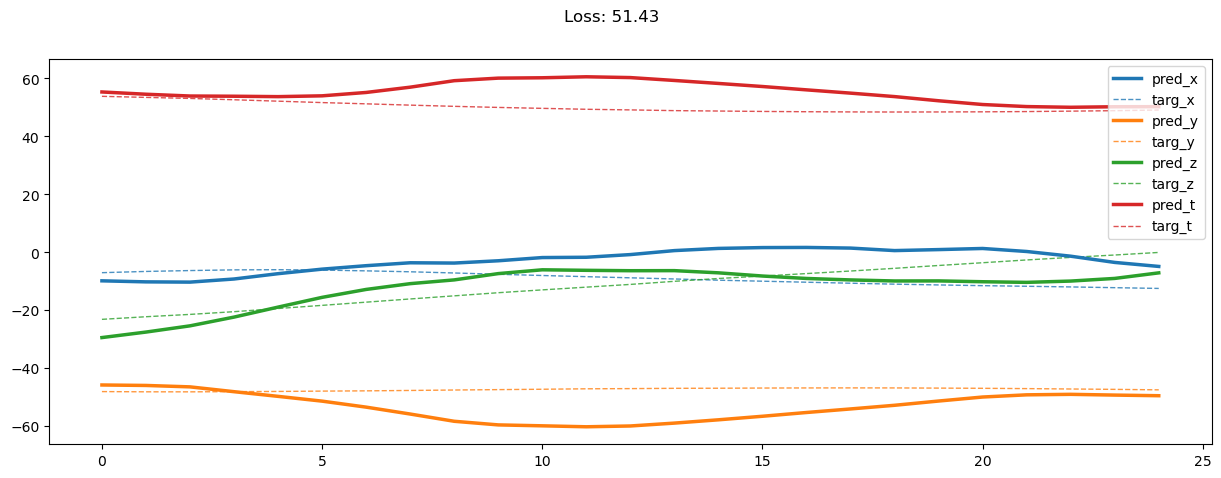

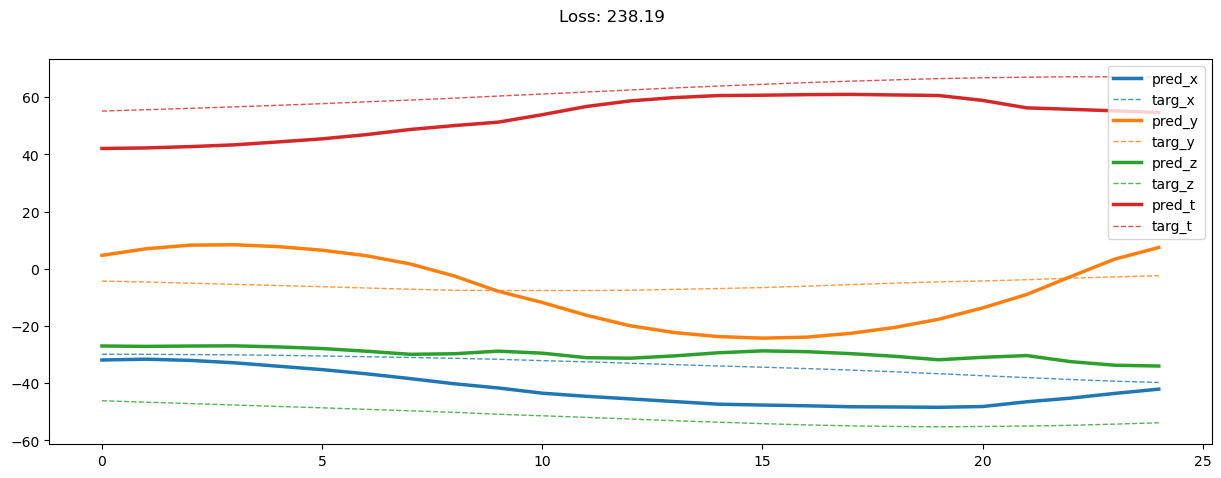

00020: train loss:  180.671, imu loss:  0.137, mag loss:  58.579, div loss:  117.556, slim:  3.539, tlim:  4.686
       valid loss:  165.338, imu loss:  0.105, mag loss:  82.212, div loss:  78.262, slim:  3.328, tlim:  5.236
00040: train loss:  180.132, imu loss:  0.136, mag loss:  58.632, div loss:  116.949, slim:  3.547, tlim:  4.704
       valid loss:  165.826, imu loss:  0.105, mag loss:  82.257, div loss:  78.677, slim:  3.413, tlim:  5.246
00060: train loss:  178.481, imu loss:  0.136, mag loss:  58.105, div loss:  115.855, slim:  3.546, tlim:  4.664
       valid loss:  168.278, imu loss:  0.104, mag loss:  83.522, div loss:  79.871, slim:  3.339, tlim:  5.261
00080: train loss:  177.578, imu loss:  0.137, mag loss:  58.025, div loss:  115.082, slim:  3.487, tlim:  4.618
       valid loss:  165.076, imu loss:  0.104, mag loss:  81.654, div loss:  78.631, slim:  3.280, tlim:  5.156
00100: train loss:  177.686, imu loss:  0.136, mag loss:  57.706, div loss:  115.491, slim:  3.529, 

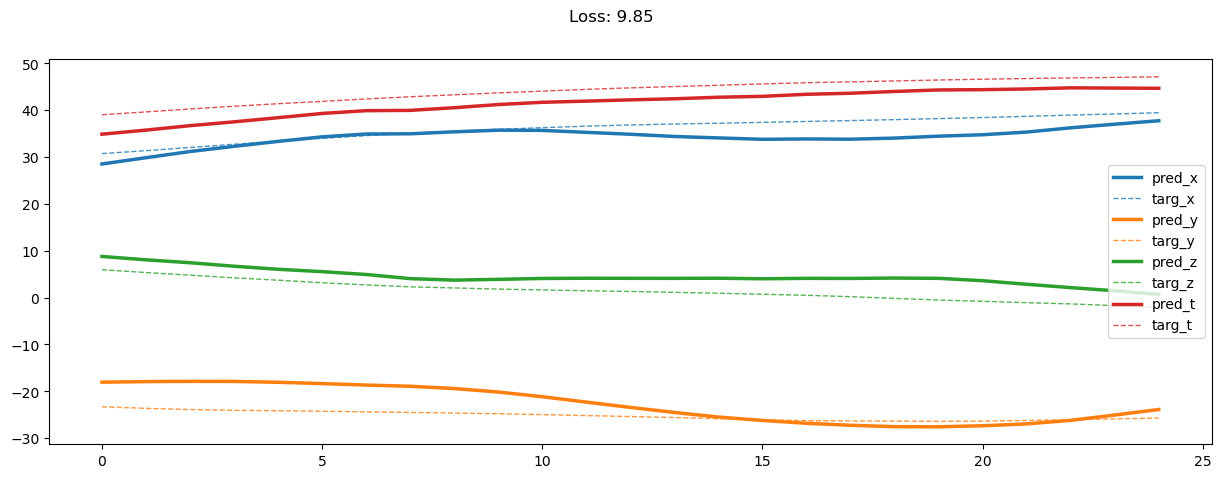

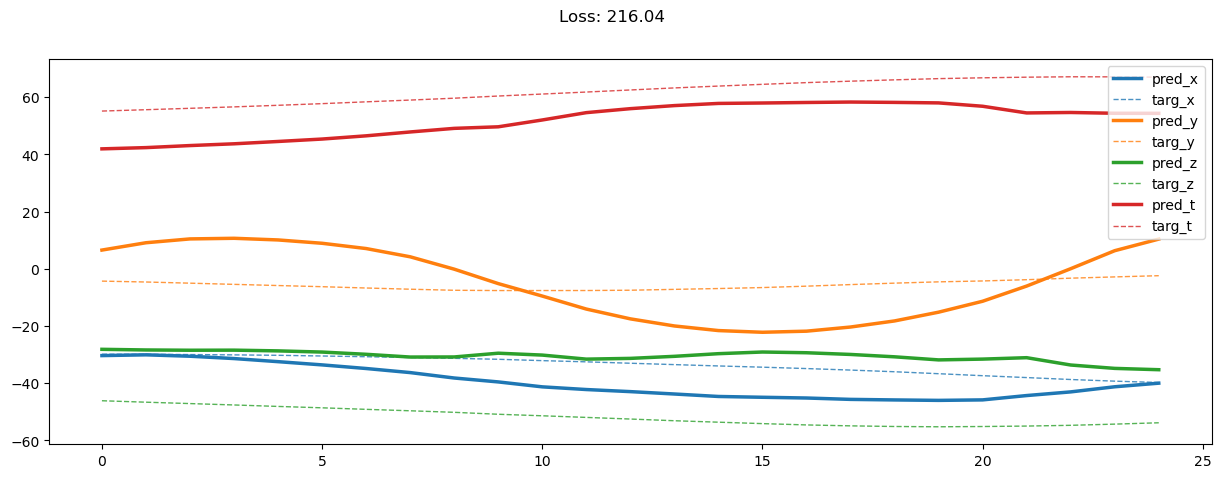

00200: train loss:  169.641, imu loss:  0.136, mag loss:  55.377, div loss:  109.862, slim:  3.484, tlim:  4.528
       valid loss:  161.797, imu loss:  0.104, mag loss:  79.429, div loss:  77.646, slim:  3.237, tlim:  5.078
00220: train loss:  171.826, imu loss:  0.136, mag loss:  55.569, div loss:  111.885, slim:  3.445, tlim:  4.499
       valid loss:  165.019, imu loss:  0.104, mag loss:  81.354, div loss:  78.882, slim:  3.371, tlim:  5.115
00240: train loss:  168.292, imu loss:  0.136, mag loss:  54.788, div loss:  109.137, slim:  3.433, tlim:  4.496
       valid loss:  162.199, imu loss:  0.104, mag loss:  79.248, div loss:  78.179, slim:  3.338, tlim:  5.111
00260: train loss:  168.561, imu loss:  0.137, mag loss:  54.729, div loss:  109.497, slim:  3.418, tlim:  4.457
       valid loss:  161.506, imu loss:  0.104, mag loss:  78.516, div loss:  78.269, slim:  3.338, tlim:  5.044
00280: train loss:  167.961, imu loss:  0.136, mag loss:  54.889, div loss:  108.770, slim:  3.361, 

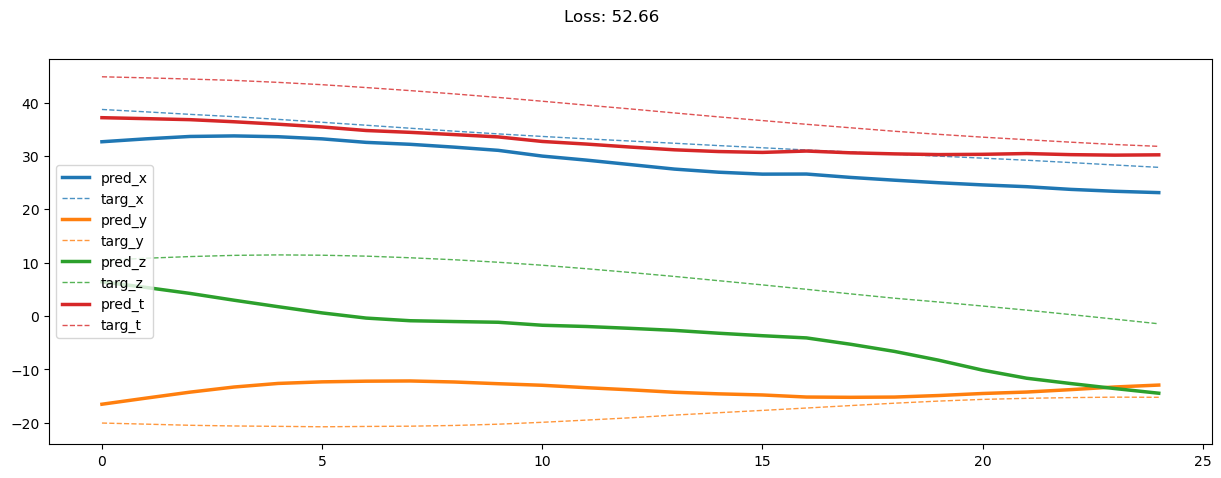

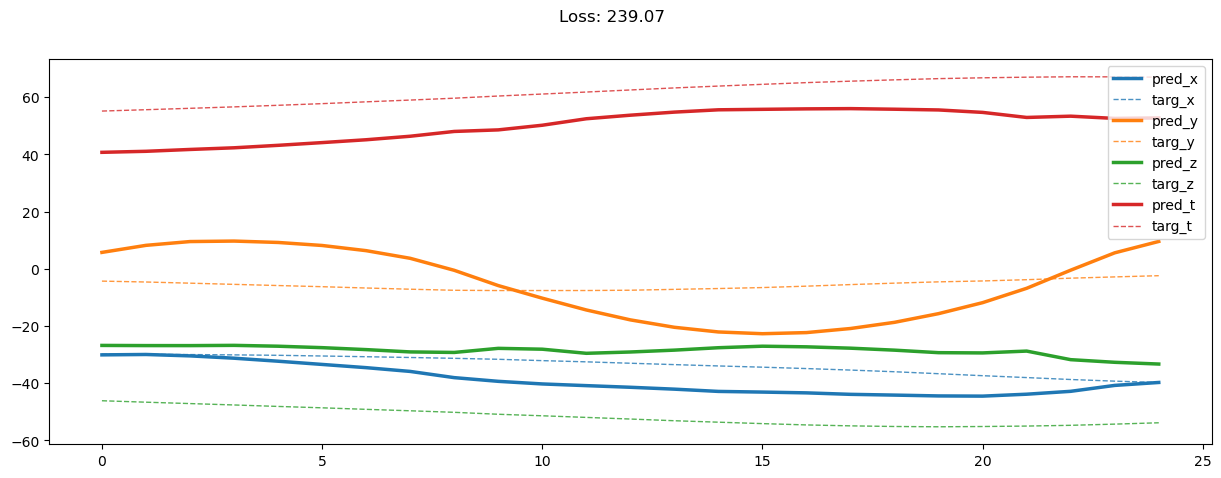

00400: train loss:  164.427, imu loss:  0.135, mag loss:  53.511, div loss:  106.641, slim:  3.428, tlim:  4.379
       valid loss:  158.904, imu loss:  0.103, mag loss:  77.189, div loss:  77.008, slim:  3.291, tlim:  5.042
00420: train loss:  160.519, imu loss:  0.136, mag loss:  52.337, div loss:  103.965, slim:  3.348, tlim:  4.325
       valid loss:  161.495, imu loss:  0.103, mag loss:  78.891, div loss:  77.954, slim:  3.283, tlim:  4.969
00440: train loss:  161.819, imu loss:  0.136, mag loss:  52.750, div loss:  104.818, slim:  3.392, tlim:  4.355
       valid loss:  159.154, imu loss:  0.103, mag loss:  77.272, div loss:  77.247, slim:  3.340, tlim:  4.928
00460: train loss:  161.147, imu loss:  0.135, mag loss:  52.282, div loss:  104.688, slim:  3.292, tlim:  4.293
       valid loss:  160.055, imu loss:  0.103, mag loss:  77.636, div loss:  77.725, slim:  3.345, tlim:  5.006
00480: train loss:  159.969, imu loss:  0.135, mag loss:  52.003, div loss:  103.764, slim:  3.359, 

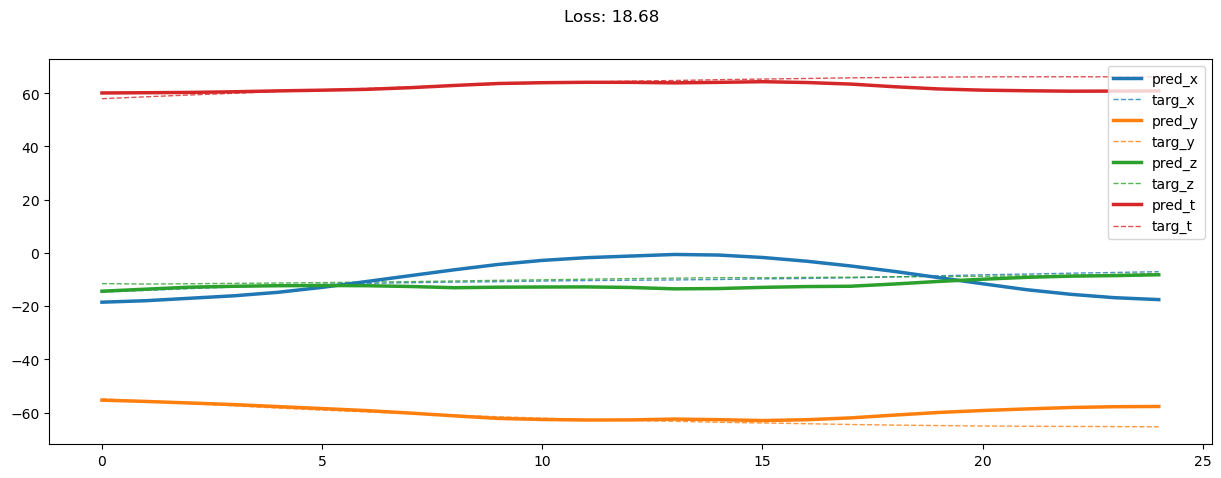

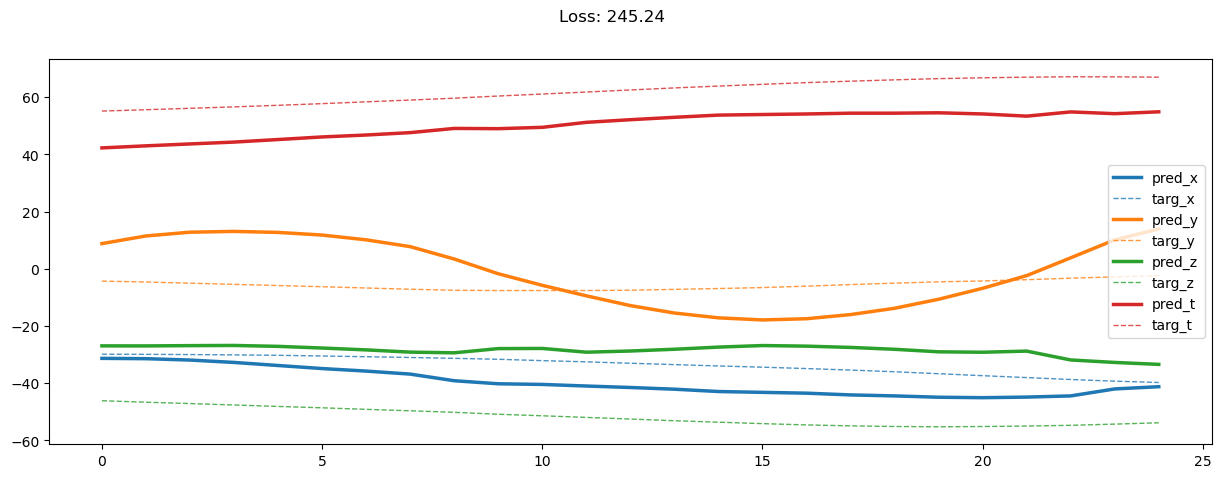

00600: train loss:  158.072, imu loss:  0.135, mag loss:  51.288, div loss:  102.647, slim:  3.334, tlim:  4.225
       valid loss:  158.946, imu loss:  0.103, mag loss:  77.039, div loss:  77.231, slim:  3.368, tlim:  4.975
00620: train loss:  157.059, imu loss:  0.135, mag loss:  51.002, div loss:  101.923, slim:  3.323, tlim:  4.224
       valid loss:  158.585, imu loss:  0.103, mag loss:  76.793, div loss:  77.145, slim:  3.330, tlim:  4.949
00640: train loss:  157.255, imu loss:  0.134, mag loss:  50.857, div loss:  102.275, slim:  3.335, tlim:  4.207
       valid loss:  158.074, imu loss:  0.103, mag loss:  76.370, div loss:  76.999, slim:  3.408, tlim:  5.001
00660: train loss:  156.218, imu loss:  0.135, mag loss:  50.840, div loss:  101.240, slim:  3.352, tlim:  4.220
       valid loss:  158.691, imu loss:  0.103, mag loss:  76.869, div loss:  77.208, slim:  3.331, tlim:  4.905
00680: train loss:  155.792, imu loss:  0.135, mag loss:  50.343, div loss:  101.308, slim:  3.389, 

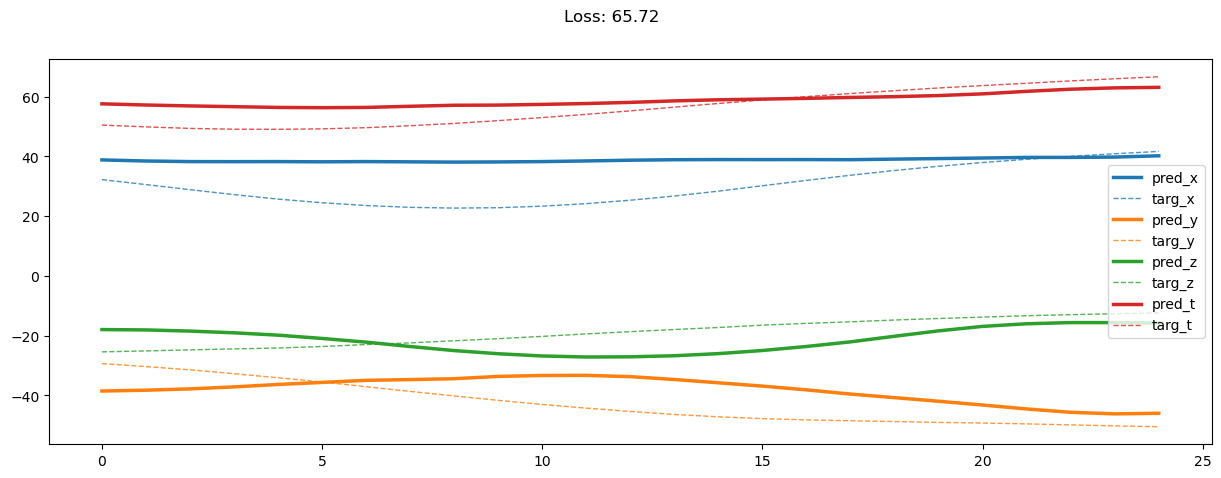

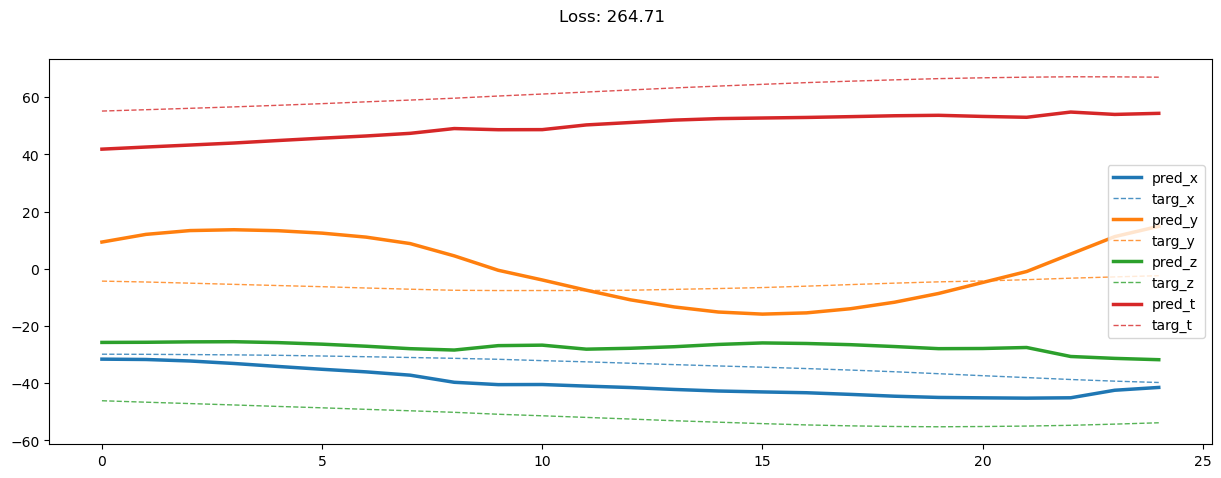

00800: train loss:  151.893, imu loss:  0.134, mag loss:  49.477, div loss:  98.348, slim:  3.304, tlim:  4.143
       valid loss:  159.041, imu loss:  0.102, mag loss:  77.036, div loss:  77.466, slim:  3.318, tlim:  4.810
00820: train loss:  151.733, imu loss:  0.134, mag loss:  49.499, div loss:  98.168, slim:  3.306, tlim:  4.139
       valid loss:  158.349, imu loss:  0.102, mag loss:  76.311, div loss:  77.474, slim:  3.249, tlim:  4.866
00840: train loss:  151.837, imu loss:  0.135, mag loss:  49.444, div loss:  98.331, slim:  3.301, tlim:  4.135
       valid loss:  160.875, imu loss:  0.102, mag loss:  78.131, div loss:  78.165, slim:  3.324, tlim:  4.862
00860: train loss:  150.256, imu loss:  0.134, mag loss:  48.850, div loss:  97.352, slim:  3.326, tlim:  4.118
       valid loss:  159.341, imu loss:  0.102, mag loss:  77.005, div loss:  77.797, slim:  3.325, tlim:  4.808
00880: train loss:  150.974, imu loss:  0.134, mag loss:  48.870, div loss:  98.056, slim:  3.317, tlim:

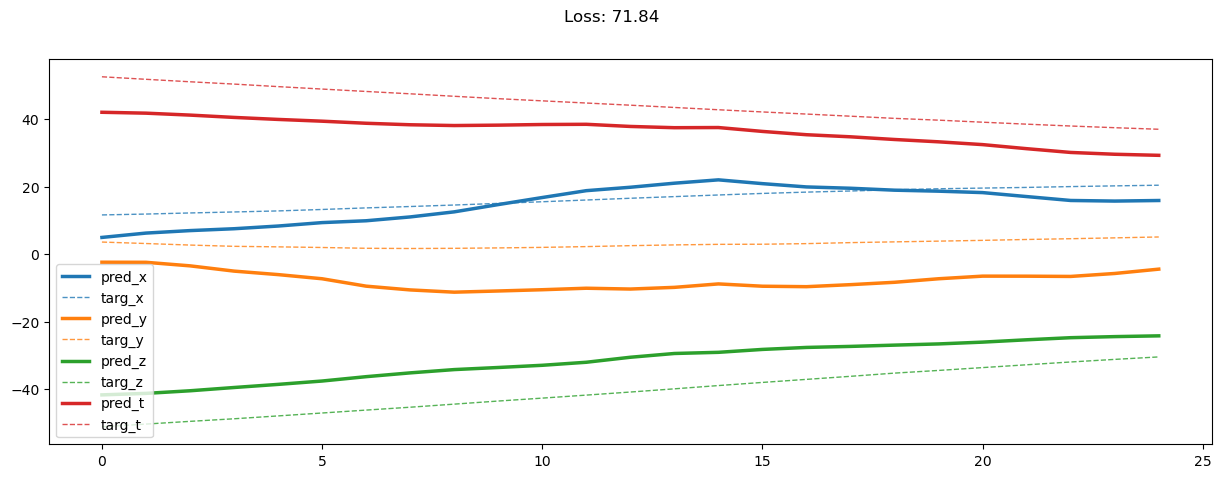

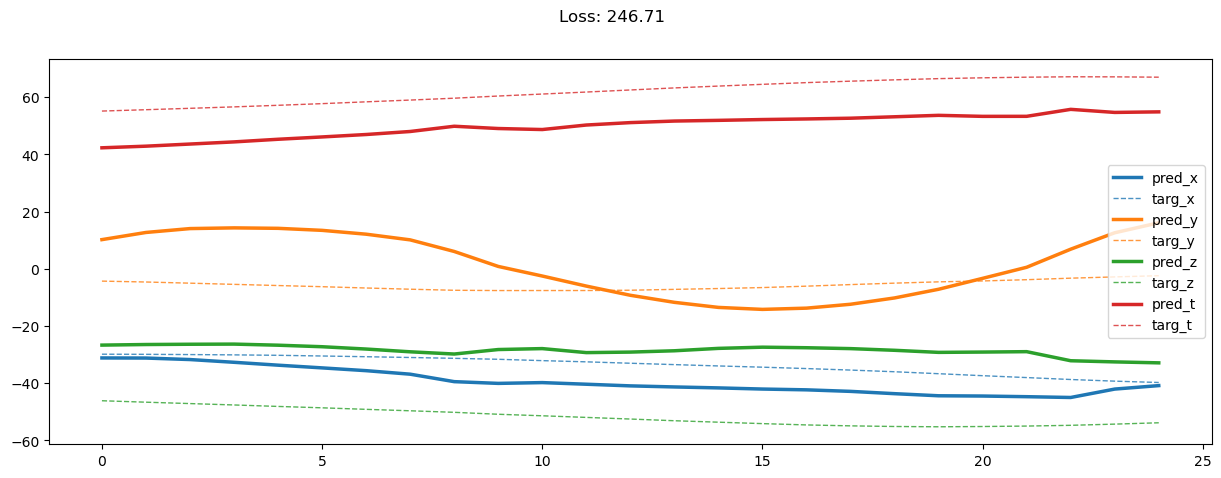

01000: train loss:  148.424, imu loss:  0.133, mag loss:  48.218, div loss:  96.172, slim:  3.328, tlim:  4.092
       valid loss:  160.858, imu loss:  0.101, mag loss:  77.772, div loss:  78.568, slim:  3.304, tlim:  4.787
01020: train loss:  148.123, imu loss:  0.134, mag loss:  48.126, div loss:  96.004, slim:  3.278, tlim:  4.051
       valid loss:  159.036, imu loss:  0.101, mag loss:  76.124, div loss:  78.331, slim:  3.408, tlim:  4.837
01040: train loss:  147.076, imu loss:  0.133, mag loss:  47.722, div loss:  95.323, slim:  3.345, tlim:  4.081
       valid loss:  162.187, imu loss:  0.101, mag loss:  78.559, div loss:  79.069, slim:  3.345, tlim:  4.829
01060: train loss:  147.695, imu loss:  0.133, mag loss:  47.815, div loss:  95.885, slim:  3.313, tlim:  4.045
       valid loss:  159.369, imu loss:  0.101, mag loss:  76.372, div loss:  78.505, slim:  3.280, tlim:  4.762
01080: train loss:  146.125, imu loss:  0.133, mag loss:  47.491, div loss:  94.632, slim:  3.317, tlim:

In [ ]:
draw = True

for epoch in range(6000):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 200 == 0:
        draw = True
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 20 == 0:
        ep = str(epoch + 1).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, imu loss: {train_imu_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}, div loss: {t_d1_loss: 2.3f}, slim: {tlim_loss[0]: 2.3f}, tlim: {tlim_loss[1]: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, imu loss: {valid_imu_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}, div loss: {v_d1_loss: 2.3f}, slim: {vlim_loss[0]: 2.3f}, tlim: {vlim_loss[1]: 2.3f}')

In [47]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :6]
            source_mag = source_data[:, :, 7:10]
            source_total_mag = source_data[:, :, 10]
            source_angle = source_data[:, :, 6]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :6]
            target_mag = target_data[:, :, 7:10]
            target_total_mag = target_data[:, :, 10]
            target_angle = source_data[:, :, 6]
            
            st_angle = torch.concat((source_angle[:, :, None], target_angle[:, :, None]), dim=-1)

            # generate mag
            source_pred_class, source_pred_one_hot = classifier.predict_label(source_imu)
            z_imu, predict_mag = model(source_imu, source_mag, source_pred_one_hot, st_angle)


            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, 3) - target_mag.reshape(len(target_mag), -1, 3), 2).mean(axis=1)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [48]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    source_label = result[2]
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'{classes[source_label]}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [ ]:
results, cres, clabel = output_eval(model, train_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::1000]:
    plot_result(rs)

In [ ]:
results, cres, clabel = output_eval(model, valid_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::100]:
    plot_result(rs)

In [51]:
def plot_eval_result(result, path):
    pred_mag = np.stack(results[:, 0], axis=0)[:, 0].reshape(-1, 3)
    targ_mag = np.stack(results[:, 1], axis=0)[:, 0].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(25, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'{path}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [52]:
def load_data(folder_path):
    source_path = os.path.join(folder_path, 'source')
    target_path = os.path.join(folder_path, 'target')

    #########################
    ##### check devices #####
    #########################
    source_path, target_path = check_data_device(source_path, target_path)

    ####################################
    ##### load and preprocess data #####
    ####################################
    source_df = load_original_data(source_path)
    target_df = load_original_data(target_path)

    source_df, target_df = bound_range(source_df), bound_range(target_df)
    source_df, target_df = align_data(source_df, target_df)
    
    return select_data(source_df), select_data(target_df)

def split_data(df):
    ncols = seq_len
    nrows = len(df) - seq_len + 1
    
    index = np.zeros((nrows, ncols), dtype=int)
    index += np.arange(ncols)
    index += np.arange(nrows).T[:, None]
    
    return df.to_numpy()[index]    

def combine_to_dataloader(source, target):
    dataset = PairDataset(
                        source_data = torch.tensor(source, dtype=torch.float),
                        source_label = np.zeros(len(source)),
                        target_data = torch.tensor(target, dtype=torch.float),
                        target_label = np.zeros(len(target)),
                    )
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False)
    
    return dataloader

def generate_dataloader(folder_path):
    source_df, target_df = load_data(folder_path)
    source_segs, target_segs = split_data(source_df), split_data(target_df)

    return combine_to_dataloader(source_segs, target_segs)

In [ ]:
for folder in ['./front_pocket/*', './pocket/*', './swing/*']:
    for path in glob.glob(folder):
        eval_loader = generate_dataloader(path)
        results, _, _ = output_eval(model, eval_loader)
        plot_eval_result(results, path)